In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from matplotlib import lines


In [3]:
z = np.random.normal(size=(200, 2))
z[0,:]= z[0,:]*0.5
np.shape(z)

(2, 200)

In [4]:
specs = np.random.normal(size=(200,10, 10))**2
np.shape(specs)

(200, 10, 10)

In [16]:
column_size = 10
pal_color = 'hls'
cmap= plt.cm.Greys
color_points = False
figsize=(10, 10)

In [22]:
def scatter_spec(
    z,
    specs,
    column_size=10,
    pal_color="hls",
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    scatter_kwargs = {
        's': 5,
        'c': 'black',
        'alpha': 1.0,
    },
    color_points=False,
    figsize=(10, 10),
    range_pad = 0.1,
    x_range = None,
    y_range = None
):
    n_columns = column_size * 4 - 4
    pal = sns.color_palette(pal_color, n_colors=n_columns)


    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(column_size, column_size)

    # prepare the main axis
    main_ax = fig.add_subplot(gs[1 : column_size - 1, 1 : column_size - 1])
    main_ax.scatter(z[0, :], z[1, :], **scatter_kwargs)
    
    if x_range is None and y_range is None:
        xmin, ymin = np.min(z, axis=1)
        xmax, ymax = np.max(z, axis=1)
        xmin -= (xmax - xmin)*range_pad
        xmax += (xmax - xmin)*range_pad
        ymin -= (ymax - ymin)*range_pad
        ymax += (ymax - ymin)*range_pad
    else:
        xmin, ymin = x_range
        ymin, ymax = y_range
    
    x_block = (xmax - xmin) / column_size
    y_block = (ymax - ymin) / column_size

    # loop through example columns
    axs = {}
    for column in range(n_columns):
        # get example column location
        if column < column_size:
            row = 0
            col = column

        elif (column >= column_size) & (column < (column_size * 2) - 1):
            row = column - column_size + 1
            col = column_size - 1

        elif (column >= ((column_size * 2) - 1)) & (column < (column_size * 3 - 2)):
            row = column_size - 1
            col = column_size - 3 - (column - column_size * 2)
        elif column >= column_size * 3 - 3:
            row = n_columns - column
            col = 0

        axs[column] = {"ax": fig.add_subplot(gs[row, col]), "col": col, "row": row}
        # label subplot
        """axs[column]["ax"].text(
            x=0.5,
            y=0.5,
            s=column,
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[column]["ax"].transAxes,
        )"""

        axs[column]["ax"].matshow(specs[column], origin="lower", interpolation="none", aspect="auto", **matshow_kwargs)

        axs[column]["ax"].set_xticks([])
        axs[column]["ax"].set_yticks([])
        if color_points:
            plt.setp(axs[column]["ax"].spines.values(), color=pal[column])

        # sample a point in z based upon the row and column
        xpos = xmin + x_block * col + x_block / 2
        ypos = ymax - y_block * row - y_block / 2
        # main_ax.text(x=xpos, y=ypos, s=column, color=pal[column])

        axs[column]["xpos"] = xpos
        axs[column]["ypos"] = ypos

    main_ax.set_xlim([xmin, xmax])
    main_ax.set_ylim([ymin, ymax])

    # create a voronoi diagram over the x and y pos points
    points = [[axs[i]["xpos"], axs[i]["ypos"]] for i in axs.keys()]

    voronoi_kdtree = cKDTree(points)
    vor = Voronoi(points)

    # plot voronoi
    # voronoi_plot_2d(vor, ax = main_ax);

    # find where each point lies in the voronoi diagram
    point_dist, point_regions = voronoi_kdtree.query(list(z.T))

    lines_list = []
    # loop through regions and select a point
    for key in axs.keys():
        # sample a point in (or near) voronoi region
        nearest_points = np.argsort(np.abs(point_regions - key))
        possible_points = np.where(point_regions == point_regions[nearest_points][0])[0]
        chosen_point = np.random.choice(a=possible_points, size=1)[0]
        point_regions[chosen_point] = 1e4
        # plot point
        if color_points:
            main_ax.scatter(
                [z[0, chosen_point]], [z[1, chosen_point]], color=pal[key], s=50
            )

        # draw a line between point and image
        mytrans = (
            axs[key]["ax"].transAxes + axs[key]["ax"].figure.transFigure.inverted()
        )

        line_end_pos = [0.5, 0.5]

        if axs[key]["row"] == 0:
            line_end_pos[1] = 0
        if axs[key]["row"] == column_size - 1:
            line_end_pos[1] = 1

        if axs[key]["col"] == 0:
            line_end_pos[0] = 1
        if axs[key]["col"] == column_size - 1:
            line_end_pos[0] = 0

        infig_position = mytrans.transform(line_end_pos)

        xpos, ypos = main_ax.transLimits.transform(
            (z[0, chosen_point], z[1, chosen_point])
        )

        mytrans2 = main_ax.transAxes + main_ax.figure.transFigure.inverted()
        infig_position_start = mytrans2.transform([xpos, ypos])

        color = pal[key] if color_points else "k"
        lines_list.append(
            lines.Line2D(
                [infig_position_start[0], infig_position[0]],
                [infig_position_start[1], infig_position[1]],
                color=color,
                lw=1,
                ls="dashed",
                transform=fig.transFigure,
                alpha=1,
            )
        )

    for l in lines_list:
        fig.lines.append(l)

    gs.update(wspace=0, hspace=0)
    # gs.update(wspace=0.5, hspace=0.5)

    fig = plt.gcf()

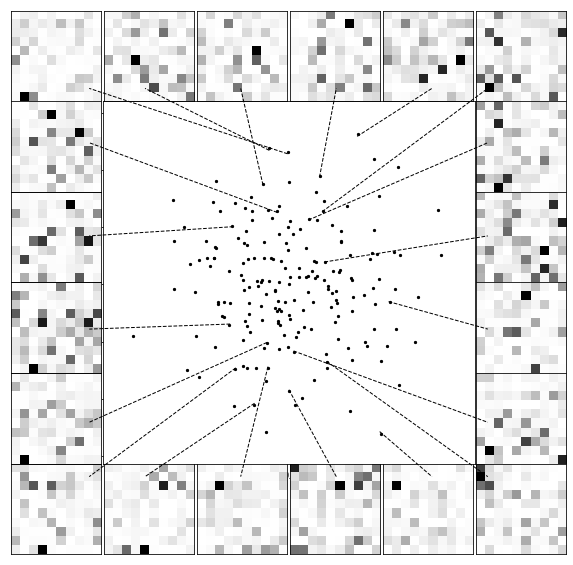

In [23]:
scatter_spec(
    z,
    specs,
    column_size=6,
    pal_color="hls",
    color_points=False,
    figsize=(10, 10),
)

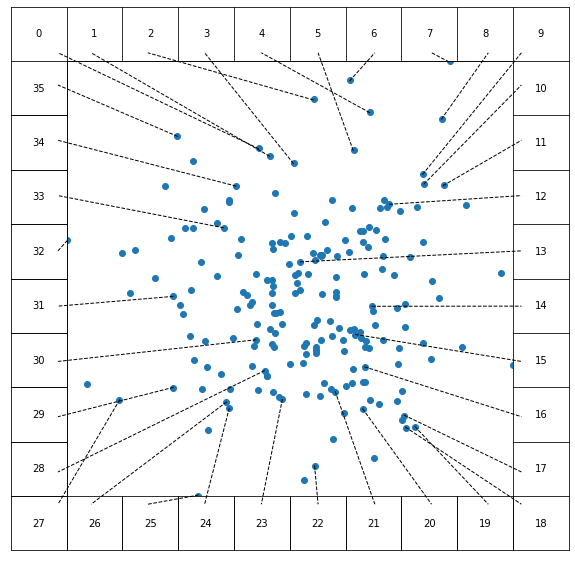

In [422]:
pal = sns.color_palette(pal_color, n_colors = n_columns)
n_columns = column_size * 4 - 4
n_columns

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(column_size, column_size)

# prepare the main axis
main_ax = fig.add_subplot(gs[1 : column_size - 1, 1 : column_size - 1])
main_ax.scatter(z[0, :], z[1, :])

xmin, ymin = np.min(z, axis=1)
xmax, ymax = np.max(z, axis=1)
x_block = (xmax - xmin) / column_size
y_block = (ymax - ymin) / column_size

# loop through example columns
axs = {}
for column in range(n_columns):
    # get example column location
    if column < column_size:
        row = 0
        col = column

    elif (column >= column_size) & (column < (column_size * 2) - 1):
        row = column - column_size + 1
        col = column_size - 1

    elif (column >= ((column_size * 2) - 1)) & (column < (column_size * 3 - 2)):
        row = column_size - 1
        col = column_size - 3 - (column - column_size * 2)
    elif column >= column_size * 3 - 3:
        row = n_columns - column
        col = 0

    axs[column] = {"ax": fig.add_subplot(gs[row, col]), "col": col, "row": row}
    axs[column]["ax"].text(
        x=0.5,
        y=0.5,
        s=column,
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[column]["ax"].transAxes,
    )

    #axs[column]["ax"].matshow(specs[column], cmap=cmap)

    axs[column]["ax"].set_xticks([])
    axs[column]["ax"].set_yticks([])
    if color_points:
        plt.setp(axs[column]["ax"].spines.values(), color=pal[column])

    # sample a point in z based upon the row and column
    xpos = xmin + x_block * col + x_block / 2
    ypos = ymax - y_block * row - y_block / 2
    # main_ax.text(x=xpos, y=ypos, s=column, color=pal[column])

    axs[column]["xpos"] = xpos
    axs[column]["ypos"] = ypos


main_ax.set_xlim([xmin, xmax])
main_ax.set_ylim([ymin, ymax])

# create a voronoi diagram over the x and y pos points
points = [[axs[i]["xpos"], axs[i]["ypos"]] for i in axs.keys()]


voronoi_kdtree = cKDTree(points)
vor = Voronoi(points)

# plot voronoi
# voronoi_plot_2d(vor, ax = main_ax);

# find where each point lies in the voronoi diagram
point_dist, point_regions = voronoi_kdtree.query(list(z.T))


lines_list = []
# loop through regions and select a point
for key in axs.keys():
    # sample a point in (or near) voronoi region
    nearest_points = np.argsort(np.abs(point_regions - key))
    possible_points = np.where(point_regions == point_regions[nearest_points][0])[0]
    chosen_point = np.random.choice(a=possible_points, size=1)[0]
    point_regions[chosen_point] = 1e4
    # plot point
    if color_points:
        main_ax.scatter([z[0, chosen_point]], [z[1, chosen_point]], color=pal[key], s=50)

    # draw a line between point and image
    mytrans = axs[key]["ax"].transAxes + axs[key]["ax"].figure.transFigure.inverted()
    
    line_end_pos = [0.5,0.5]
    
    if axs[key]['row'] == 0:
        line_end_pos[1] = 0
    if axs[key]['row'] == column_size-1:
        line_end_pos[1] = 1
        
    if axs[key]['col'] == 0:
        line_end_pos[0] = 1
    if axs[key]['col'] == column_size-1:
        line_end_pos[0] = 0

    infig_position = mytrans.transform(line_end_pos)

    xpos, ypos = main_ax.transLimits.transform((z[0, chosen_point], z[1, chosen_point]))

    mytrans2 = main_ax.transAxes + main_ax.figure.transFigure.inverted()
    infig_position_start = mytrans2.transform([xpos, ypos])

    color = pal[key] if color_points else 'k'
    lines_list.append(
        lines.Line2D(
            [infig_position_start[0], infig_position[0]],
            [infig_position_start[1], infig_position[1]],
            color=color,
            lw=1,
            ls="dashed",
            transform=fig.transFigure,
            alpha=1,
        )
    )


for l in lines_list:
    fig.lines.append(l)


gs.update(wspace=0, hspace=0)
# gs.update(wspace=0.5, hspace=0.5)


fig = plt.gcf()